## Toy Problem

We want to solve a simple PDE:
$$
    (a_\epsilon u')'(x) = 1, \quad  x\in [0,1], \qquad u(0)=u(1) = 0.
$$
where $a_\epsilon(x) = A(x, x/\epsilon)$ and $\epsilon = 1/N > 0$ for some integer $N$, and $A$ is periodic in the second argument.

in the special case when $a_\epsilon(x) = \mathrm{const} = \tilde a$, we have
$$
    \tilde u(x) = \frac{x(x-1)}{2\tilde a}.
$$
We parameterize 
$$
\tilde a = \frac{1}{(\phi \circledast a_\epsilon^{-1})(0)},
$$
where $\phi$ is an unknown convolutional kernel (the optimal $\phi$ according to homogenization is $1$). Then, the difference between $u$ and $\tilde u$ at a point $x$ is
$$
    u(x; a_\epsilon) - \tilde u(x; \tilde a) =  u(x; a_\epsilon) - \frac{x(x-1)}{2}(\phi \circledast a_\epsilon^{-1})(0)
$$
This is a specific PDE where $\tilde a$ is known. In general, we seek the optimal $\tilde a$ for cases when the optimal is not known.


In [23]:
import torch
from torch.fft import fft, ifft
import matplotlib.pyplot as plt

atilde = 0.1
N = 2000
x = torch.linspace(0, 1, N)
eps = 0.1

inner = lambda phi_vec, afunc: eps * torch.mean(phi_vec / afunc(torch.linspace(0, eps, len(phi_vec))))
solve_constant = lambda x, aconst: x*(x-1)/(2 * aconst)



def solve_variable(afunc, N):
    x = torch.linspace(0, 1, N)
    dx = 1/(N-1)
    a = afunc(x)
    A = (-2*torch.diag(a[1:-1], 0) + torch.diag(a[2:-1], -1) + torch.diag(a[1:-2], 1)) / dx**2
    b = torch.ones(N-2)
    return torch.cat([torch.tensor([0]), torch.linalg.solve(A, b), torch.tensor([0])])


def loss(atilde, afunc):
    return torch.mean((solve_variable(afunc, N) - solve_constant(x, atilde))**2)

def find_optimal_a(a0):
    a = torch.tensor(a0, requires_grad=True)
    optimizer = torch.optim.Adam([a], lr=0.001)
    for i in range(500):
        optimizer.zero_grad()
        l = loss(a, afunc)
        l.backward()
        optimizer.step()
        if i % 100 == 0:
            print(l)
    return a.item()

afunc = lambda x: atilde + 0.99*atilde*torch.round(torch.sin(x/eps*2*torch.pi))
atilde_optimal = 1/inner(torch.ones_like(x)/eps, afunc)
atilde_learned = find_optimal_a(atilde)
print(f"Optimal a: {atilde_optimal}, Learned a: {atilde_learned}, Guess: {atilde}")


tensor(895.6046, grad_fn=<MeanBackward0>)
tensor(6.4708, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
Optimal a: 0.0029584690928459167, Learned a: 0.0029593671206384897, Guess: 0.1


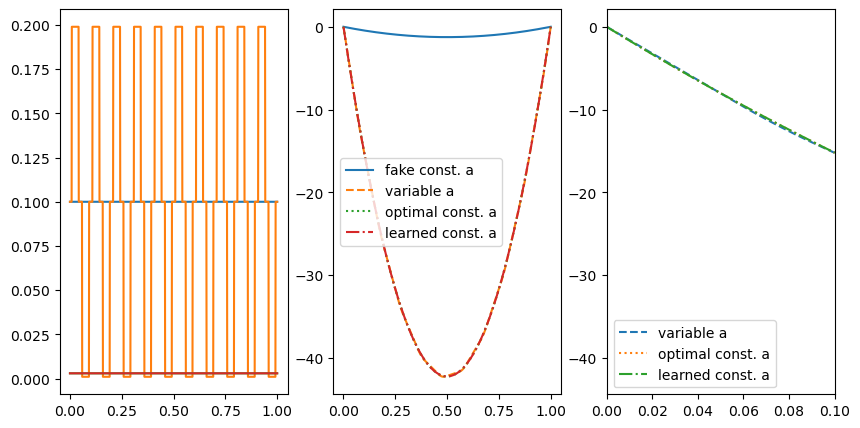

In [29]:

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.plot(x, atilde*torch.ones_like(x), label="fake a")
plt.plot(x, afunc(x), label="a(x)")
plt.plot(x, atilde_optimal*torch.ones_like(x), label="optimal const a")
plt.plot(x, atilde_learned*torch.ones_like(x), label="learned const a")
plt.subplot(132)
plt.plot(x, solve_constant(x, atilde), label="fake const. a")
plt.plot(x, solve_variable(afunc, N), '--', label="variable a")
plt.plot(x, solve_constant(x, atilde_optimal), ':', label="optimal const. a")
plt.plot(x, solve_constant(x, atilde_learned), '-.', label="learned const. a")
plt.legend()
plt.subplot(133)
plt.plot(x, solve_variable(afunc, N), '--', label="variable a")
plt.plot(x, solve_constant(x, atilde_optimal), ':', label="optimal const. a")
plt.plot(x, solve_constant(x, atilde_learned), '-.', label="learned const. a")
plt.xlim(0, 0.1)
plt.legend()

In [25]:
torch.diag(torch.ones(3), 1)

tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])